In [0]:
from os.path import exists
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch

Google colab environment code, this platform is super bad, I won't use it again :).

In [6]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 22280 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.0-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleus

In [0]:

import csv
import numpy as np
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl

In [0]:
def data_preprocess(path, size):
    
    premise=[]
    hypo = []
    label =[]
    
    with open(path) as files:
        file = csv.reader(files, delimiter='\t')
        for row in file:
            if row != ['sentence1', 'sentence2', 'label']:
                premise.append(row[0].split())
                hypo.append(row[1].split())
                if row[2] == 'contradiction':
                    label.append(-1.0)
                elif row[2]=='entailment':
                    label.append(1.0)
                elif row[2]=='neutral': 
                    label.append(0.0)
                else:
                    print('Error Label')
    return premise, hypo, label 
                

In [0]:
s1_train, s2_train, y_train = data_preprocess('/content/drive/hw2_data/snli_train.tsv', 100000)
s1_val, s2_val, y_val = data_preprocess('/content/drive/hw2_data/snli_val.tsv', 1000)

In [4]:
print(s1_train[1])
print(s2_train[1])
print(y_train[1])

['A', 'woman', 'is', 'smiling', 'while', 'the', 'man', 'next', 'to', 'her', 'is', 'focused', 'on', 'a', 'blue', 'object', 'with', 'a', 'pattern', 'on', 'it', '.']
['Two', 'people', 'are', 'next', 'to', 'each', 'other', '.']
1.0


In [0]:
import io

def load_vectors(fname,size):
    PAD_IDX = 0
    UNK_IDX = 1
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = np.zeros((size+2, 300))
    
    token2id = {'<pad>':PAD_IDX, '<unk>':UNK_IDX}
    id2token = {PAD_IDX:'<pad>', UNK_IDX:'<unk>'}
    np.random.seed(1)
    data[UNK_IDX] = np.random.rand(300)
    i =0
    for line in fin:
        i +=1
        if i>size:
            break
        tokens = line.rstrip().split(' ')
        data[i+1, :] = np.asarray(tokens[1:])
        token2id[tokens[0]] = i+1
        id2token[i+1] = tokens[0]

    return data, token2id, id2token

In [0]:
dictionary_size= 100000
PAD_IDX = 0
UNK_IDX = 1
vector_load, token2id, id2token= load_vectors('/content/drive/hw2_data/wiki-news-300d-1M.vec',dictionary_size)

In [6]:
import random
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 49493 ; token Kosher
Token Kosher; token id 49493


In [0]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [0]:
s1_train_indices = token2index_dataset(s1_train)
s2_train_indices=token2index_dataset(s2_train)
s1_val_indices= token2index_dataset(s1_val)
s2_val_indices=token2index_dataset(s2_val)

In [9]:
s1_train_indices[10034]

[1442, 3135, 403, 8, 3, 13654, 4]

In [13]:
s1_train[10034]

['Two', 'dogs', 'play', 'in', 'the', 'surf', '.']

In [0]:
l1 = [len(i) for i in s1_train]
MAX_SENTENCE_LENGTH_1 = int(np.percentile(l1, 99))

l2 = [len(i) for i in s2_train]
MAX_SENTENCE_LENGTH_2 = int(np.percentile(l2, 99))

In [12]:
print ("The max length of 99 percent sentences in train: {} ; The max length of 99 percent sentences in val: {}".format(MAX_SENTENCE_LENGTH_1 , MAX_SENTENCE_LENGTH_2 ))


The max length of 99 percent sentences in train: 34 ; The max length of 99 percent sentences in val: 19


In [0]:
import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list1,data_list2, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list1 = data_list1
        self.data_list2 = data_list2
        self.target_list = target_list
        assert (len(self.data_list1) == len(self.target_list))
        assert (len(self.data_list2) == len(self.target_list))
    def __len__(self):
        return len(self.data_list1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx1 = self.data_list1[key][:MAX_SENTENCE_LENGTH_1]
        token_idx2 = self.data_list2[key][:MAX_SENTENCE_LENGTH_2]
        label = self.target_list[key]
        return [token_idx1, len(token_idx1), token_idx2, len(token_idx2), label]
              

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []

    
    for datum in batch:
        label_list.append(datum[4])
        length_list1.append(datum[1])
        length_list2.append(datum[3])

    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH_1-datum[1])), 
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)        
        
        
        padded_vec2 = np.pad(np.array(datum[2]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH_2-datum[3])), 
                                mode="constant", constant_values=0)

        data_list2.append(padded_vec2)
    
    return [torch.from_numpy(np.array(data_list1)), torch.LongTensor(length_list1), 
            torch.from_numpy(np.array(data_list2)), torch.LongTensor(length_list2),torch.LongTensor(label_list)]
  
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(s1_train_indices, s2_train_indices, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(s1_val_indices, s2_val_indices, y_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)  




#CNN

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR


class SNLI_CNN(nn.Module):
    def __init__(self, kernel_size, hidden_size1, hidden_size2, num_layers, num_classes, pad_size):

        super(SNLI_CNN, self).__init__()
        
        self.num_layers =num_layers
        self.hidden_size1 = hidden_size1 
        self.hidden_size2 = hidden_size2
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(vector_load)).float()
        
        
        emb_size=300
        #for s1
        self.convs11 = nn.Conv1d(emb_size, hidden_size1, kernel_size=kernel_size, padding=pad_size)
        self.convs12 = nn.Conv1d(hidden_size1, hidden_size1, kernel_size=kernel_size, padding=pad_size)
        self.maxpools1 = nn.MaxPool1d(MAX_SENTENCE_LENGTH_1)
        
        #for s2
        self.convs21 = nn.Conv1d(emb_size, hidden_size1, kernel_size=kernel_size, padding=pad_size)
        self.convs22 = nn.Conv1d(hidden_size1, hidden_size1, kernel_size=kernel_size, padding=pad_size)
        self.maxpools2 = nn.MaxPool1d(MAX_SENTENCE_LENGTH_2)

        self.linear1 = nn.Linear(2*hidden_size1, hidden_size2)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size2, num_classes)

    def forward(self, s1, s1_len, s2, s2_len):
        batch_size1, s1_len = s1.size()
        batch_size2, s1_len = S2.size()

        embed1 = self.embedding(s1)        
        hidden1 = self.convs11(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, s1_len, hidden1.size(-1))
        hidden1 = self.convs12(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size1, hidden1.size(-1), s1_len)
        hidden1 = self.maxpools1(hidden1)
        
        
        embed2 = self.embedding(s2)
        hidden2 = self.convs21(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, s2_len, hidden2.size(-1))
        hidden2 = self.convs22(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size2, hidden2.size(-1), s2_len)   
        hidden2 = self.maxpools2(hidden2)
        
        
        combined_vector = torch.cat([hidden1, hidden2],dim=1)
        cnn_out = torch.sum(combined_vector, dim=-1)        
        sum_fc_out = self.linear1(cnn_out)
        fc_out = self.relu(sum_fc_out)
        logits = self.linear2(fc_out)
        
        return logits
   

In [0]:
def test_model(loader, model):
    model.eval()
    cor = 0
    cnt = 0


    for s1, s1_l,  s2, s2_1, labels in loader:
        s1_batch1, batch1_1, s2_batch2, batch2_1, label_batch = s1, s1_l, s2, s2_1, labels
        
        
        outputs = F.softmax(model(s1_batch1, batch1_1, s2_batch2, batch2_1), dim=1)
        predict = outputs.max(1, keepdim=True)[1]

        cnt += labels.size(0)
        cor += predicted.eq(labels.view_as(predict)).sum().item()
        accu = cor / cnt * 100
        
        
    return (accu)


In [0]:
def train_model(model,num_epochs, adj, dropout=0.1, save=False,learning_rate,  model_name='rnn'):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])

    
    criterion = torch.nn.CrossEntropyLoss()
   # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    


    train_ls = []
    train_acc = []
    val_acc = []
    for epoch in range(num_epochs):
        if adj:
            scheduler.step()
        for i, (s1, s1_l, s2, s2_l, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            result = model(s1, s1_l, s2, s2_l)
            loss = criterion(result, labels)
            loss.backward()
            optimizer.step()
            
            
            
            
            
            train_ls.append(loss)
            # validate every 1000 iterations
            if i > 0 and i % 1000 == 0:
                # validate
                train_acc.append(test_model(train_loader, model))
                #val_accuracy = test_model(val_loader, model)
                val_acc.append(test_model(val_loader, model))
                #print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( epoch+1, num_epochs, i+1, len(train_loader), val_accuracy))
    
    val_acc_last = test_model(val_loader, model)
   # print("CNN Model: Hidden Size: {}; fc_dim: {}; Kernel Size: {} ".format(model.hidden_size,model.fc_dim,model.kernel_size))
  
  
    print("Parameters: Learning Rate:{}; Num_epoch:{}; adjust_learning:{}".format(learning_rate, num_epochs, adj))
    print("Val Accuracy:{}".format(val_acc_last))
    print("Number of trainable parameters:{}".format(params))

    plt.figure(figsize=(16,6))
    plt.subplot(1, 2, 1)
    plt.plot(train_ls)
    plt.xlabel('iteration')
    plt.ylabel('train Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train Acc%')
    plt.plot(val_acc, label='val Acc%')
    plt.xlabel("iteraton/1000")
    plt.ylabel("accuracy%")
    plt.show()
    return model   


In [0]:
model = SNLI_CNN(hidden_size = 100,fc_dim = 50,kernel_size = 3,padding = 1,dropout = 0.1,num_classes=3,emb_dim = 300)
#train_model(model, 3e-4, 1, False, model_name='cnn')

CNN Model: Hidden Size1: 100; Hidden_size2: 50; Kernel Size: 3; Pad Size: 1
Parameters: Learning Rate:0.0005; Num_epoch:5; adjust_learning:False
Val Accuracy:65.9
Number of trainable parameters:250603


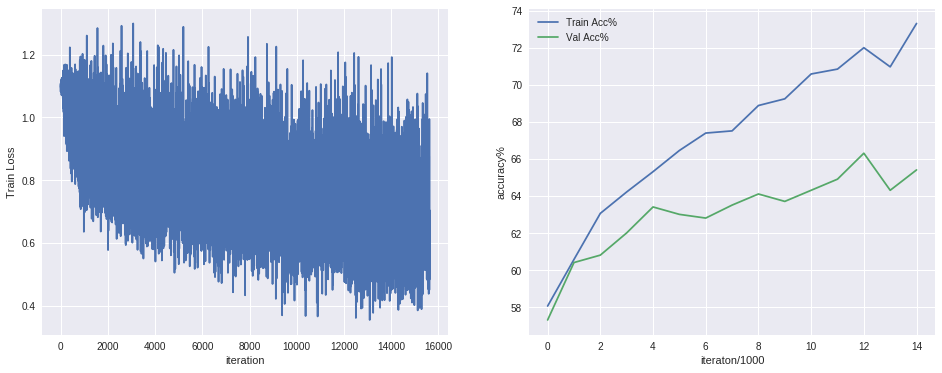

In [13]:
print("CNN Model: Hidden Size1: {}; Hidden_size2: {}; Kernel Size: {}; Pad Size: {}".format(100,50, 3,1))
model = SNLI_CNN(kernel_pad=[3,1], hidden_size1=100, hidden_size2=50, num_layers=2, num_classes=3)
Model =train_model(model, 5e-4, 5, False, model_name='cnn')
pkl.dump(Model, open('/content/drive/hw2_data/'+'CNN_model3'+'.sav', 'wb'))

CNN Model: Hidden Size1: 100; Hidden_size2: 50; Kernel Size: 5; Pad Size: 2
Parameters: Learning Rate:0.0005; Num_epoch:5; adjust_learning:False
Val Accuracy:66.1
Number of trainable parameters:410603


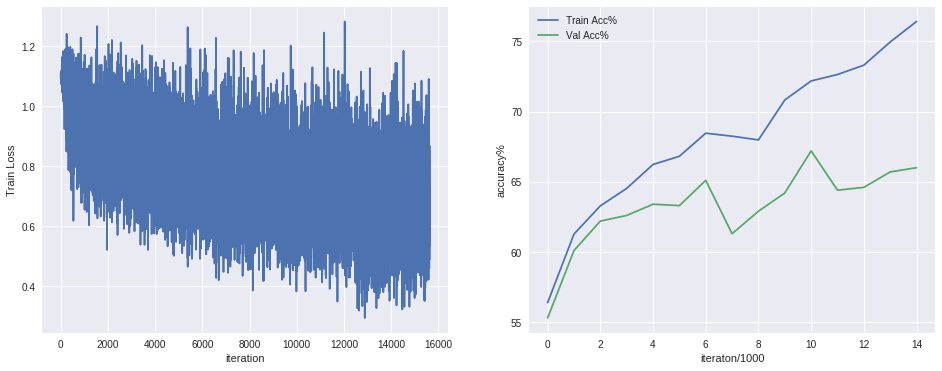

In [14]:
print("CNN Model: Hidden Size1: {}; Hidden_size2: {}; Kernel Size: {}; Pad Size: {}".format(100,50, 5,2))
model = SNLI_CNN(kernel_pad=[5,2], hidden_size1=100, hidden_size2=50, num_layers=2, num_classes=3)

Model =train_model(model, 5e-4, 5, False, model_name='cnn')
pkl.dump(Model, open('/content/drive/hw2_data/'+'CNN_model4'+'.sav', 'wb'))

CNN Model: Hidden Size1: 200; Hidden_size2: 100; Kernel Size: 5; Pad Size: 2
Parameters: Learning Rate:0.0005; Num_epoch:5; adjust_learning:False
Val Accuracy:63.0
Number of trainable parameters:1041203


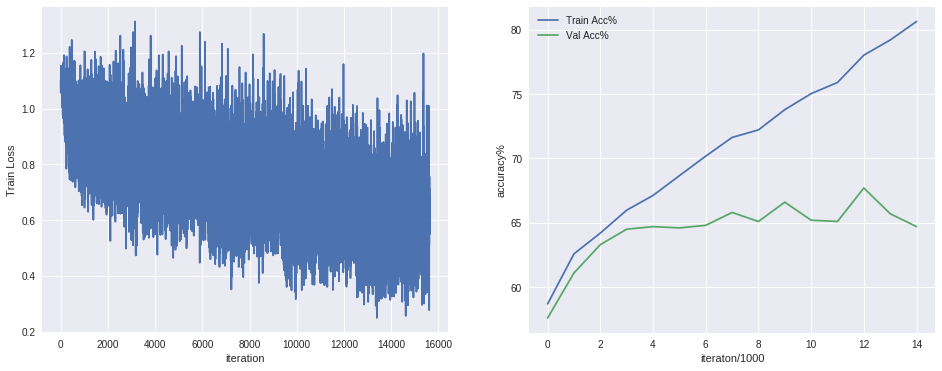

In [15]:
print("CNN Model: Hidden Size1: {}; Hidden_size2: {}; Kernel Size: {}; Pad Size: {}".format(200,100, 5,2))
model = SNLI_CNN(kernel_pad=[5,2], hidden_size1=200, hidden_size2=100, num_layers=2, num_classes=3)

Model =train_model(model, 5e-4, 5, False, model_name='cnn')
pkl.dump(Model, open('/content/drive/hw2_data/'+'CNN_model5'+'.sav', 'wb'))

CNN Model: Hidden Size1: 200; Hidden_size2: 100; Kernel Size: 5; Pad Size: 2
Parameters: Learning Rate:0.0005; Num_epoch:5; adjust_learningTrue
Val Accuracy:65.3
Number of trainable parameters:1041203


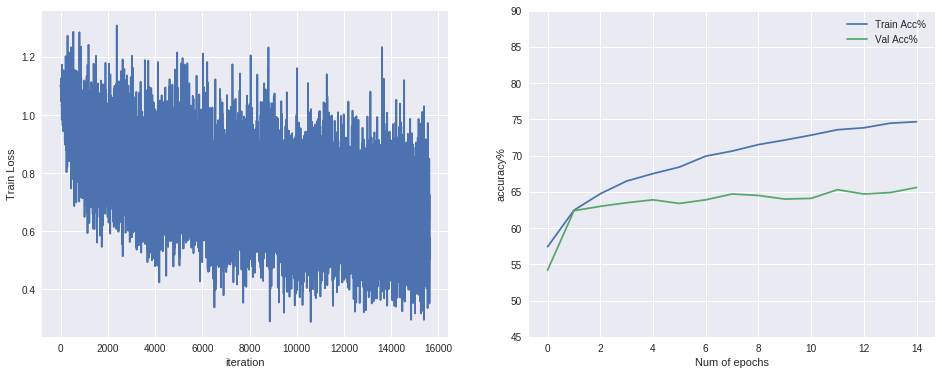

In [57]:
print("CNN Model: Hidden Size1: {}; Hidden_size2: {}; Kernel Size: {}; Pad Size: {}".format(200,100, 5,2))
model = SNLI_CNN(kernel_pad=[5,2], hidden_size1=200, hidden_size2=100, num_layers=2, num_classes=3)

Model =train_model(model, 5e-4, 5, True, model_name='cnn')


In [0]:
pkl.dump(Model, open('/content/drive/hw2_data/'+'CNN_model2'+'.sav', 'wb'))

CNN Model: Hidden Size1: 200; Hidden_size2: 100; Kernel Size: 5; Pad Size: 2
Parameters: Learning Rate:0.005; Num_epoch:5; adjust_learning:False
Val Accuracy:62.3
Number of trainable parameters:1041203


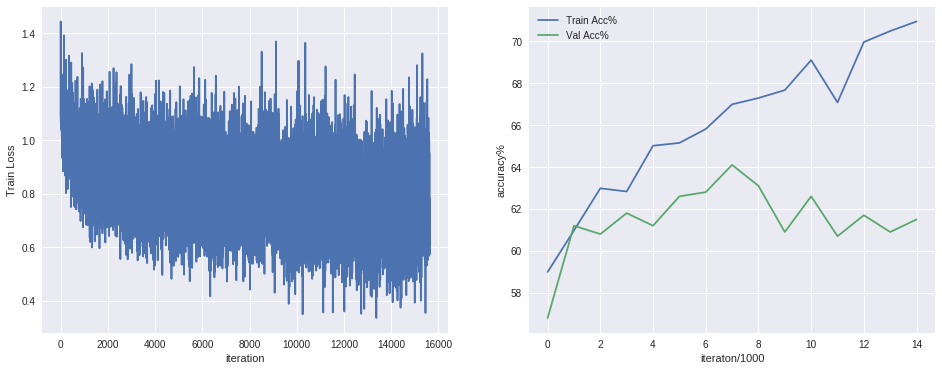

In [16]:
print("CNN Model: Hidden Size1: {}; Hidden_size2: {}; Kernel Size: {}; Pad Size: {}".format(200,100, 5,2))
model = SNLI_CNN(kernel_pad=[5,2], hidden_size1=200, hidden_size2=100, num_layers=2, num_classes=3)

Model =train_model(model, 5e-3, 5, False, model_name='cnn')
pkl.dump(Model, open('/content/drive/hw2_data/'+'CNN_model6'+'.sav', 'wb'))

CNN Model: Hidden Size1: 200; Hidden_size2: 100; Kernel Size: 5; Pad Size: 2
Parameters: Learning Rate:0.005; Num_epoch:5; adjust_learning:False
Val Accuracy:64.1
Number of trainable parameters:641203


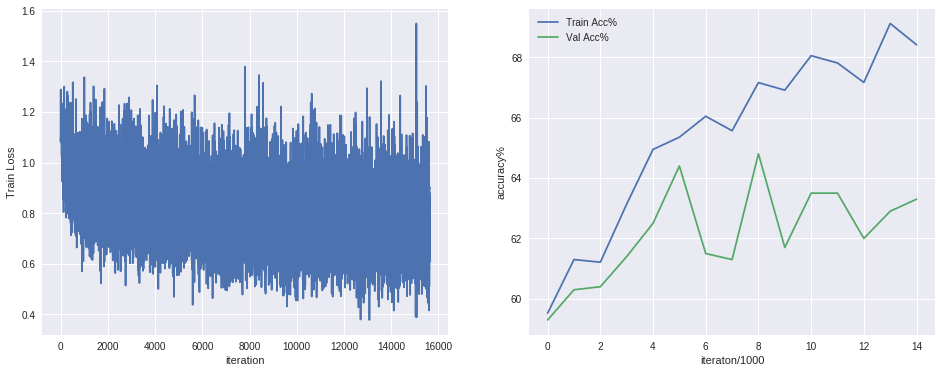

In [19]:
print("CNN Model: Hidden Size1: {}; Hidden_size2: {}; Kernel Size: {}; Pad Size: {}".format(200,100, 5,2))
model = SNLI_CNN(kernel_pad=[3,1], hidden_size1=200, hidden_size2=100, num_layers=2, num_classes=3)
Model =train_model(model, 5e-3, 5, False, model_name='cnn')
pkl.dump(Model, open('/content/drive/hw2_data/'+'CNN_model7'+'.sav', 'wb'))

#RNN

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F







In [0]:

class SNLI_RNN(nn.Module):
    def __init__(self, hidden_size, hidden2_size, fc_size, num_layers, num_classes, emb_size=300):

        super(SNLI_RNN, self).__init__()

        self.num_layers = num_layer
        self.hidden_size =hidden_size
        self.hidden2_size = hidden2_size
        self.fc_size = fc_size

        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(vector_load)).float()
        self.rnnL1 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.rnnL2 = nn.GRU(emb_size, hidden2_size, num_layers, batch_first=True, bidirectional=True)
      
        
        self.linearL1 = nn.Linear(hidden_size+hidden2_size, fc_size)
        self.relu = nn.ReLU()
        self.linearL2 = nn.Linear(fc_size, num_classes)  
        
        
        
        
    def initialize(self, batch_size, hidden_size):

        hidden = torch.randn(self.num_layers*2, batch_size, hidden_size)
        return hidden
            
        self.hidden1 = self.initialize(batch_size1, self.hidden_size)
        self.hidden2 = self.initialize(batch_size2, self.hidden2_size)
        
    def forward(self, s1, s1_len, s2, s2_len):
        batch_size1, seq_len1 = s1.size()
        batch_size2, seq_len2 = s2.size()
        
        _, s1_sort = torch.sort(s1_len, dim=0, descending=True)
        _, s1_sort2 = torch.sort(s1_sort, dim=0)
        _, s2_sort = torch.sort(s2_len, dim=0, descending=True)
        _, is2_sort2 = torch.sort(s2_sort, dim=0)

        

   
                
        embed_s1 = self.embedding(s1)
        embed_s2 = self.embedding(s2)

        embed_s1 = embed_s1.index_select(0, s1_sort)
        embed_s1 = torch.nn.utils.rnn.pack_padded_sequence(embed_s1, s1_len.index_select(0, s1_sort).numpy(), batch_first=True)
        embed_s2 = embed_s2.index_select(0, s2_sort)
        embed_s2 = torch.nn.utils.rnn.pack_padded_sequence(embed_s2, s2_len.index_select(0, s2_sort).numpy(), batch_first=True)

        
        
        
        rnn_out1, self.hidden1 = self.rnnL1(embed_s1, self.hidden1)
        self.hidden1 = self.hidden1.index_select(1, s1_sort2)
        rnn_out2, self.hidden2 = self.rnnL2(embed_s2, self.hidden2)
        self.hidden2 = self.hidden2.index_select(1, is2_sort2)

        combined_vector = torch.cat([self.hidden1, self.hidden2],dim=-1)
        rnn_out = torch.sum(combined_vector, dim=0)
        
        

        fc_out = self.linearL1(rnn_out)
        fc_out = self.relu(fc_out)
        logits = self.linearL2(fc_out)
        
        return logits

RNN Model: Hidden Layer Size: 200; : Memory layer size: 150; Fully connected layer size: 100
Parameters: Learning Rate:0.0005; Num_epoch:5; adjust_learningFalse
Val Accuracy:68.6
Number of trainable parameters:1044603


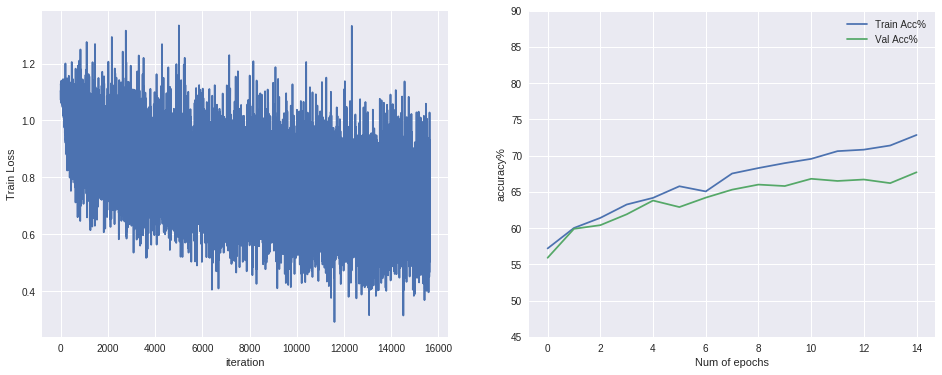

In [0]:
print("RNN Model: Hidden Layer Size: {}; : Memory layer size: {}; Fully connected layer size: {}".format(200,150,100))
model = SNLI_RNN(hidden_size=200, hidden_size2=150, hidden_size3=100, num_layers=1, num_classes=3)
Model = train_model(model, 5e-4, 5, False, save=True)
pkl.dump(Model, open('/content/drive/hw2_data/'+'RNN_model1'+'.sav', 'wb'))

RNN Model: Hidden Layer Size: 150; : Memory layer size: 100; Fully connected layer size: 50
Parameters: Learning Rate:0.0005; Num_epoch:5; adjust_learning:False
Val Accuracy:65.4
Number of trainable parameters:660703


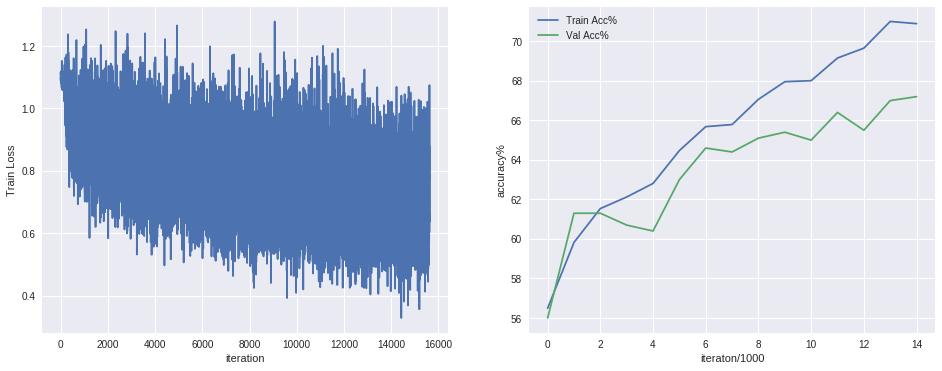

In [18]:
print("RNN Model: Hidden Layer Size: {}; : Memory layer size: {}; Fully connected layer size: {}".format(150,100,50))
model = SNLI_RNN(hidden_size=150, hidden_size2=100, hidden_size3=50, num_layers=1, num_classes=3)
Model = train_model(model, 5e-4, 5, False, save=True)
pkl.dump(Model, open('/content/drive/hw2_data/'+'RNN_model2'+'.sav', 'wb'))

RNN Model: Hidden Layer Size: 200; : Memory layer size: 150; Fully connected layer size: 100
Parameters: Learning Rate:0.0005; Num_epoch:5; adjust_learning:True
Val Accuracy:66.1
Number of trainable parameters:1044603


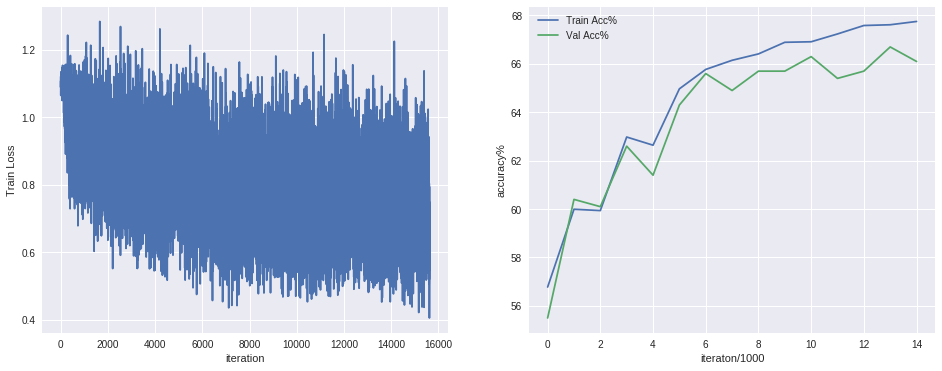

In [20]:
print("RNN Model: Hidden Layer Size: {}; : Memory layer size: {}; Fully connected layer size: {}".format(200,150,100))
model = SNLI_RNN(hidden_size=200, hidden_size2=150, hidden_size3=100, num_layers=1, num_classes=3)
Model = train_model(model, 5e-4, 5, True, save=True)
pkl.dump(Model, open('/content/drive/hw2_data/'+'RNN_model3'+'.sav', 'wb'))

RNN Model: Hidden Layer Size: 200; : Memory layer size: 150; Fully connected layer size: 100
Parameters: Learning Rate:0.005; Num_epoch:5; adjust_learning:False
Val Accuracy:61.5
Number of trainable parameters:1044603


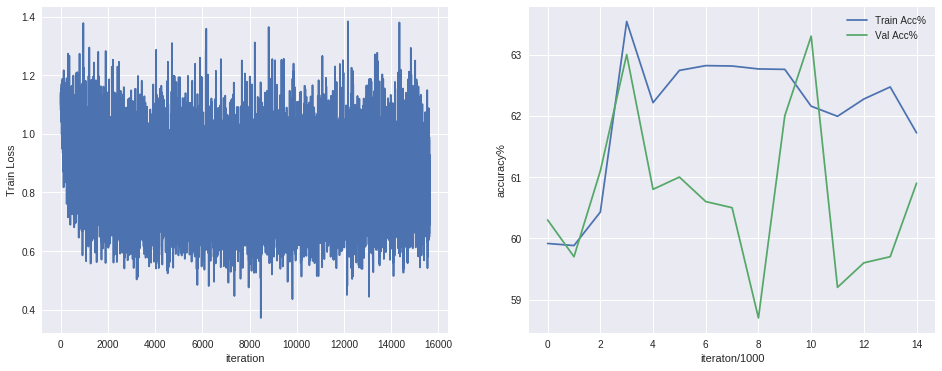

In [18]:
print("RNN Model: Hidden Layer Size: {}; : Memory layer size: {}; Fully connected layer size: {}".format(200,150,100))
model = SNLI_RNN(hidden_size=200, hidden_size2=150, hidden_size3=100, num_layers=1, num_classes=3)
Model = train_model(model, 5e-3, 5, False, save=True)
pkl.dump(Model, open('/content/drive/hw2_data/'+'RNN_model4'+'.sav', 'wb'))

RNN Model: Hidden Layer Size: 200; : Memory layer size: 150; Fully connected layer size: 100
Parameters: Learning Rate:0.0005; Num_epoch:3; adjust_learning:False
Val Accuracy:66.6
Number of trainable parameters:1044603


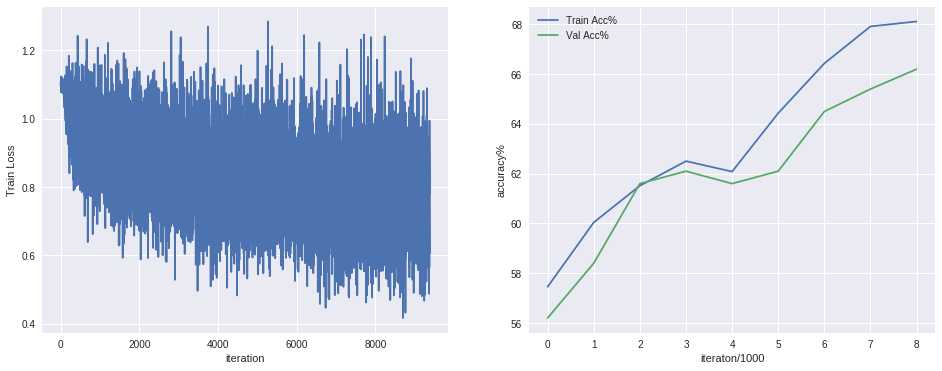

In [17]:
print("RNN Model: Hidden Layer Size: {}; : Memory layer size: {}; Fully connected layer size: {}".format(200,150,100))
model = SNLI_RNN(hidden_size=200, hidden_size2=150, hidden_size3=100, num_layers=1, num_classes=3)
Model = train_model(model, 5e-4, 3, False, save=True)
pkl.dump(Model, open('/content/drive/hw2_data/'+'RNN_model5'+'.sav', 'wb'))

In [0]:
def predictor(loader, model):
    model.eval()
    all_s1 = []
    all_s2 = []
    all_label = []
    
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputss1, outputss2 = F.softmax(model(data_batch, length_batch), dim=1)
        predictor = [x.item() for x in outputs.max(1, keepdim=True)[1]]
        all_predictor.append(predictor)
        all_s1.append(outputss1)
        all_s2.append(outputss2)
        all_label += [x.item() for x in labels]
    return (all_s1, all_s2, all_predictor, all_label)

Predictions Sample:

Correct samples:

In [37]:
all_s1,all_s2, all_predictor, all_lab = predictor(val_loader, Model)
wrong_s1 =[]
wrong_s1 =[]
right_s1= []
right_s2= []
right_cnt = 0
wrong_cnt=0
right_label=[]
predict=[]

for i in range(15000):
    if all_pred[i] != all_lab[i]:
        wrong_pred_recorder.append((all_test[i], all_lab[i]))
        predict.append(all_pred[i])
        wrong_cnt +=1
    else:
        right_pred_recorder.append((all_test[i], all_lab[i]))
        right_cnt +=1
    if (wrong_cnt==3 and right_cnt==3):
        break

for i in range(3):
    print("Primise: {}".format(str(right_s1[i])))
    print("Hypothesis: {}".format(str(right_s2[i])))
    print("Label: {}".format(right_label[i]))


Primise: ['A', 'female', 'laying', 'on', 'her', 'stomach', 'in', 'the', 'water', 'outside', 'with', 'umbrellas', '.']
Hypothesis: ['There', 'is', 'a', 'women', 'outdoors']
Label: 1.0
Primise: ['A', 'red', 'jeep', 'hangs', 'from', 'the', 'edge', 'of', 'a', 'rocky', 'cliff', 'as', 'a', 'girl', 'looks', 'on', '.']
Hypothesis: ['The', 'vehicle', 'is', 'red', '.']
Label: 1.0
Primise: ['A', 'woman', 'is', 'sitting', 'in', 'a', 'street', 'market', 'stand', 'where', 'there', 'are', 'various', 'items', 'for', 'sale', ',', 'such', 'as', 'fish', '.']
Hypothesis: ['The', 'woman', 'is', 'in', 'a', 'street', 'market', '.']
Label: 1.0


Incorrect samples:

In [75]:
for i in range(3):
    print("Primise: {}".format(str(wrong_s1[i])))
    print("Hypothesis: {}".format(str(wrong])))
    print("Our result: {}".format(str(predict[i])))
    print("Label: {}".format(wrongl[i]))

Primise: ['A', 'kid', 'in', 'a', 'red', 'and', 'black', 'coat', 'is', 'laying', 'on', 'his', 'back', 'in', 'the', 'snow', 'with', 'his', 'arm', 'in', 'the', 'air', 'and', 'a', 'red', 'sled', 'is', 'next', 'to', 'him', '.']
Hypothesis: ['The', 'kid', 'is', 'on', 'a', 'sugar', 'high', '.']
Our result: 0.0
Label: -1.0
Primise: ['Two', 'older', 'men', 'speak', 'into', 'microphones', 'on', 'a', 'stage', ',', 'while', 'a', 'projector', 'screen', 'displays', 'a', 'vintage', 'photo', 'of', 'a', 'young', 'man', 'behind', 'them', '.']
Hypothesis: ['Two', 'men', 'are', 'sitting', 'handcuffed', 'in', 'a', 'police', 'station', '.']
Our result: 1.0
Label: -1.0
Primise: ['An', 'outside', 'wedding', 'ceremony', 'for', 'an', 'asian', 'couple', 'under', 'an', 'umbrella', ',', 'shielded', 'from', 'the', 'blaring', 'sun', '.']
Hypothesis: ['Asian', 'people', 'getting', 'married', 'by', 'the', 'beach', '.']
Our result: 1.0
Label: 0.0
